In [17]:
# //////////////////////////////////////////////////////// Data Reading & Cleaning //////////////////////////////////////////////////
import codecs
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

data=codecs.open('socialmedia-disaster-tweets-DFE.csv',encoding='utf8', errors='replace') #use something other than binary mode or the default encoding

file=codecs.open('nonUnicode_clean.csv','w','utf8')
for line in data:
    file.write(line)
file.close()

data=pd.read_csv('nonUnicode_clean.csv')
data['class_label']=[1 if a=='Relevant' else 0 if a=='Not Relevant'else 2 for a in data['choose_one']]
data=data[['text','choose_one','class_label']]

def cleaning_text(df, col_name):
    df[col_name] = df[col_name].str.replace(r"http\S+", "").replace(r"http", "")\
        .replace(r"@\S+", "").replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")\
        .replace(r"@", "at")
    df[col_name] = df[col_name].str.replace(r"#", "")
    df[col_name] = df[col_name].str.lower()
    return df

data = cleaning_text(data, "text")
data.to_csv('proper_clean_data.csv') #for further use

In [19]:
# //////////////////////////////////////////////////////// TOKENIZING //////////////////////////////////////////////////
# tokenization is the process of breaking up a piece of "TEXT" into many pieces, such as sentences and words. it works by separating words using spaces and punctuation.
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'\w+')
data["tokens"] = data["text"].apply(token.tokenize)
print("\n\n\t\t\t\t******************** TOKENIZING ********************\n")
data.head()



				******************** TOKENIZING ********************



,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake ma...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, st...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask. canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"




				******************** dataset table with classes names ********************

              text  class_label  tokens
choose_one                             
Can't Decide    16           16      16
Not Relevant  6187         6187    6187
Relevant      4673         4673    4673


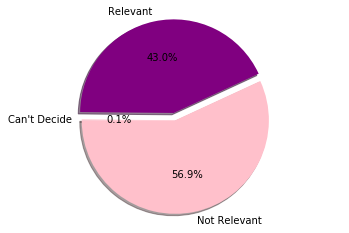

 158661 words in total with a vocabulary size of 21267


In [38]:
# //////////////////////////////////////////////////////// Inspecting dataset //////////////////////////////////////////////////
print("\n\n\t\t\t\t******************** dataset table with classes names ********************\n")
print(data.groupby(['choose_one']).count())

lab = data.groupby(['choose_one']).groups.keys()
val = data['choose_one'].value_counts()
exp = [0.0, 0.08, 0.0]
fig1, ax1 = plt.subplots()
ax1.pie(val, colors={'purple', 'pink'}, explode=exp, labels=['Not Relevant', "Relevant", "Can't Decide"],
        autopct='%1.1f%%', shadow=True, startangle=180)
ax1.axis('equal')
plt.show()
# //
words = [word for token in data['tokens'] for word in token]
unique_word = set(words)
print('', len(words), 'words in total with a vocabulary size of', len(unique_word))

In [39]:
# //////////////////////////////////////////////////////// Enter embeddings //////////////////////////////////////////////////
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

text=data["text"].tolist()
label=data["class_label"].tolist()
x_train,x_test,y_train,y_test=train_test_split(text,label,test_size=.30,random_state=5)

In [5]:
# //////////////////////////////////////////////////////// Bag of words count ////////////////////////////////////////////////
cnt_vec = CountVectorizer()  # count
x_train_cnt = cnt_vec.fit_transform(x_train)
x_test_cnt = cnt_vec.transform(x_test)
print("\n\n***************** bag of words count: \t\t", x_train_cnt.shape)
# print(cnt_vec.get_feature_names())
# print(x_train_cnt.shape) # will print(#of rows,#unique words) (7613, 16988)
# print(x_test_cnt)



***************** bag of words count: 		 (7613, 21643)


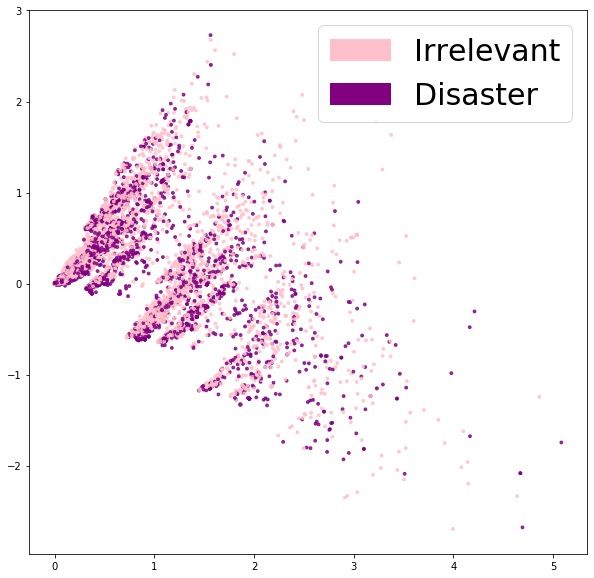

In [24]:
# //////////////////////////////////////////////////////// Visualizing the embeddings ////////////////////////////////////////
from sklearn.decomposition import TruncatedSVD
import matplotlib.colors as col
import matplotlib.patches as mpatches

# Now that we've created embeddings, let's visualize them and see if we can identify some structure.Since
# visualizing data in almost 17k dimensions is hard, let's project it down to 2.
def plot_LSA(data, labels):
    lsa = TruncatedSVD(n_components=2)
    lsa_scores = lsa.fit_transform(data)
    colors = ['pink', 'purple', 'pink']
    plt.figure(figsize=(10, 10))
    plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8, c=labels, cmap=col.ListedColormap(colors))
    red_patch = mpatches.Patch(color='pink', label='Irrelevant')
    green_patch = mpatches.Patch(color='purple', label='Disaster')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
plt.show()
plot_LSA(x_train_cnt, y_train)

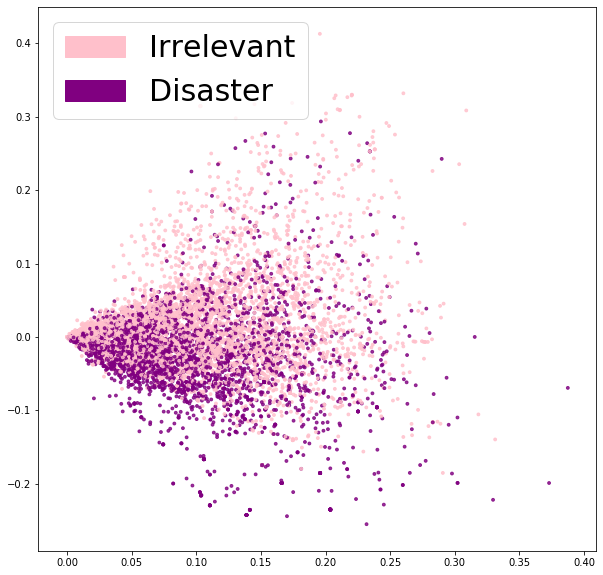

In [36]:
# //////////////////////////////////////////////////////// Fitting a classifier ////////////////////////////////////////
# We will use logistic regression . It is simple, often gets the job done, and is easy to interpret.
from sklearn.linear_model import LogisticRegression

tfidf_vec=TfidfVectorizer()
x_train_tfidf=tfidf_vec.fit_transform(x_train)
x_test_tfidf=tfidf_vec.transform(x_test)

plot_LSA(x_train_tfidf,y_train)

model_tfidf=LogisticRegression(C=30.0,class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=5)
model_tfidf.fit(x_train_tfidf, y_train)
predicted_tfidf=model_tfidf.predict(x_test_tfidf)


In [52]:
# //////////////////////////////////////////////////////// Evaluation ////////////////////////////////////////
print(classification_report(y_test,predicted_tfidf))
print('Accuracy: %.2f%%'%(accuracy_score(y_test,predicted_tfidf)*100))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1859
           1       0.76      0.73      0.74      1399
           2       0.00      0.00      0.00         5

    accuracy                           0.78      3263
   macro avg       0.52      0.52      0.52      3263
weighted avg       0.78      0.78      0.78      3263

Accuracy: 78.39%


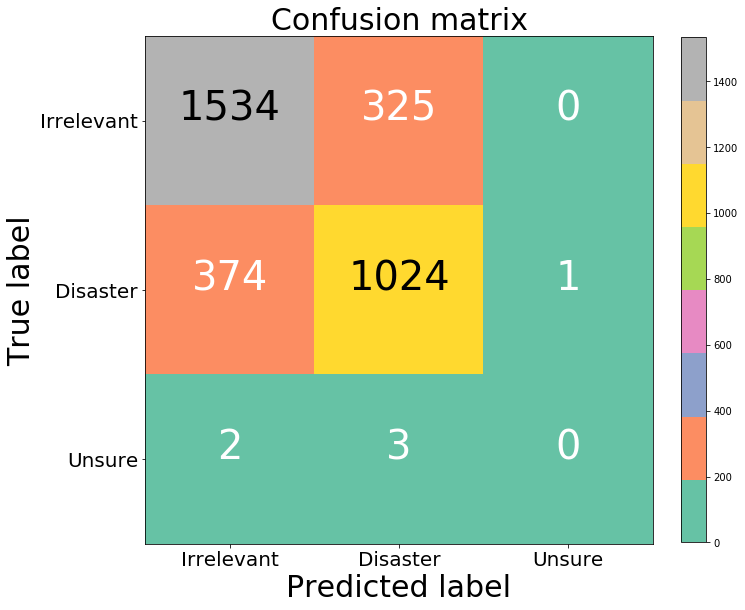

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,title,cmap=plt.cm.Set2):
    a=plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar(fraction=.045)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
   
    fmt ='d'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
   
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt
cm = confusion_matrix(y_test,predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'],title='Confusion matrix')
plt.show()

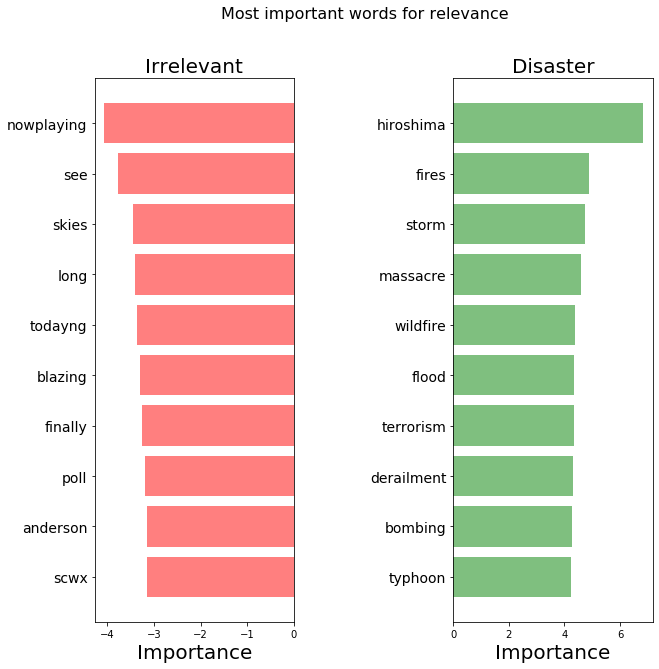

In [47]:
# //////////////////////////////////////////////////////// Further inspection ////////////////////////////////////////
def important_features(vectorizer, model, n=5):
    index_to_word = {idx:word for word,idx in vectorizer.vocabulary_.items()}

    classes ={}
    for class_idx in range(model.coef_.shape[0]):
        word_importances = [(val, index_to_word[word_idx]) for word_idx,val in enumerate(model.coef_[class_idx])]
        sorted_coeff = sorted(word_importances)
        bottom  = sorted_coeff[:n]
        bottom.reverse()
        top = sorted_coeff[-n:]
        classes[class_idx] = {
            'tops':top,
            'bottom':bottom
        }
    return classes
def plot_important_words(data, name,n):
    y_pos = np.arange(n)

    top_scores = [a[0] for a in data[1]['tops']]
    top_words = [a[1] for a in data[1]['tops']]
    bottom_scores = [a[0] for a in data[1]['bottom']]
    bottom_words = [a[1] for a in data[1]['bottom']]
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5,color='red')
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
   
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,color='green')
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
   
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
importance =important_features(tfidf_vec,model_tfidf,10)
plot_important_words( importance,"Most important words for relevance",10)